<a href="https://colab.research.google.com/github/FIlipeRBLuz/Data-Science/blob/master/NLP_RECLAME_AQUI_V2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, validation_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from nltk import WordNetLemmatizer, TextCollection
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from nltk.probability import FreqDist
from scipy import interp
from itertools import cycle
import re
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
import wordcloud
#import lime
#from lime.lime_text import LimeTextExplainer 
#from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')
print(plt.style.available)

['seaborn-pastel', 'seaborn-bright', '_classic_test', 'seaborn-paper', 'seaborn-notebook', 'seaborn-talk', 'seaborn-whitegrid', 'ggplot', 'grayscale', 'seaborn-dark-palette', 'seaborn-poster', 'classic', 'seaborn-dark', 'dark_background', 'fivethirtyeight', 'seaborn-ticks', 'seaborn', 'seaborn-colorblind', 'seaborn-white', 'Solarize_Light2', 'seaborn-muted', 'fast', 'tableau-colorblind10', 'seaborn-deep', 'bmh', 'seaborn-darkgrid']


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df_ranking=pd.read_csv('gdrive/My Drive/Colab Notebooks/ranking.csv')

In [0]:
df_ranking.head()

,companyId,companyName,rank_melhores,rank_piores,rank_mais_reclamada
0,103,Banco Bradesco,NaN,NaN,0
1,2406,Banco Itaú,NaN,NaN,1
2,98,Banco Santander,NaN,NaN,2
3,27198,Banco do Brasil,NaN,NaN,3
4,12949,Banco Inter,NaN,NaN,4


In [0]:
df_reclamacoes = pd.read_csv('gdrive/My Drive/Colab Notebooks/reclamacoes.csv')

In [0]:
df_reclamacoes.head()

NameError: ignored

In [0]:
len(df_reclamacoes)

502930

In [0]:
#@title Definindo dataset contendo apenas reclamações avaliadas


In [0]:
df_reclamacoes = df_reclamacoes[df_reclamacoes.evaluated != False]

In [0]:
#df_interacoes = pd.read_csv('gdrive/My Drive/Colab Notebooks/interações_final.csv',sep=',', engine='python',error_bad_lines=False)

In [0]:
# Merge utilizando coluna CompanyId como chave
df_reclamacoes = df_ranking.merge(df_reclamacoes, left_on="companyId", right_on="companyId")

In [0]:
# Atribuindo colun ID como indice para facilitar etapa de merge
df_reclamacoes = df_reclamacoes.set_index("id")

In [0]:
len(df_reclamacoes)

188612

In [0]:
df_reclamacoes.head()

,companyId,companyName_x,rank_melhores,rank_piores,rank_mais_reclamada,solved,evaluation,userState,modified,evaluated,read,created,frozen,status,userCity,description,title,complainOrigin,firstInteractionDate,hasReply,category,companyName_y
id,,,,,,,,,,,,,,,,,,,,,,
L_lWpWWSl7kl_qS_,103,Banco Bradesco,NaN,NaN,0,True,Fui muito bem atendido e a quetão prontamente ...,SP,2016-07-21T16:14:23,True,False,2016-07-16 17:26:58,False,ANSWERED,São Pedro,A dois meses atrás recebi uma ligação de uma f...,Cobrança indevida,MOBILE,2016-07-21T11:13:11,False,1.0,Banco Bradesco
_80Jzvn7f8WNyKNr,103,Banco Bradesco,NaN,NaN,0,True,Nota 10 mais uma vez para a gerência da minha ...,SP,2017-12-29T15:45:51,True,False,2017-12-21 15:47:15,False,ANSWERED,São Paulo,Ao fazer uma transferência de conta corrente B...,Cobrança de transferência de Bradesco para Bra...,SITE,2017-12-28T07:29:57,False,1.0,Banco Bradesco
EmgR3wMrYN_Qeiqz,103,Banco Bradesco,NaN,NaN,0,False,o problema não foi resolvido,MG,2018-10-15T09:40:37,True,True,2018-10-06 09:58:17,False,ANSWERED,Belo Horizonte,no dia 26/09/2018 foi descontado de minha cont...,desconto indevido,SITE,2018-10-10T15:13:06,True,-1.0,Banco Bradesco
xRqCsdh2nWXkbTDk,103,Banco Bradesco,NaN,NaN,0,True,Resolvido,MG,2017-09-05T11:41:12,True,False,2017-08-29 10:52:53,False,ANSWERED,Paraisópolis,Sou correntista do Banco Bradesco e trabalho c...,Certidão Simplificada do Banco Bradesco Pende...,SITE,2017-08-31T08:56:35,False,NaN,Banco Bradesco
uFk9cGeGy0J3vJQ2,103,Banco Bradesco,NaN,NaN,0,True,A pessoa que me atendeu me deu uma dica de usa...,PE,2017-03-19T12:50:09,True,False,2017-02-21 20:13:35,False,ANSWERED,Recife,"Boa noite,este mês de fevereiro foi descontado...",Cobrança de tarifa bancária,SITE,2017-03-02T16:31:11,False,1.0,Banco Bradesco


In [0]:
banco_unsolved = df_reclamacoes[['companyName_x', 'solved']][df_reclamacoes['solved'] == False].groupby(['companyName_x']).count()
banco_solved = df_reclamacoes[['companyName_x', 'solved']][df_reclamacoes['solved'] == True].groupby(['companyName_x']).count()

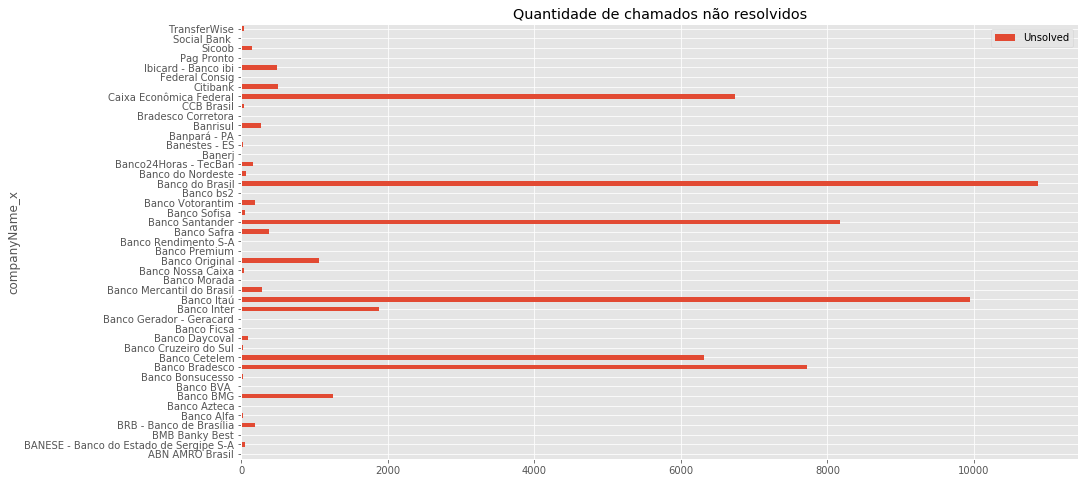

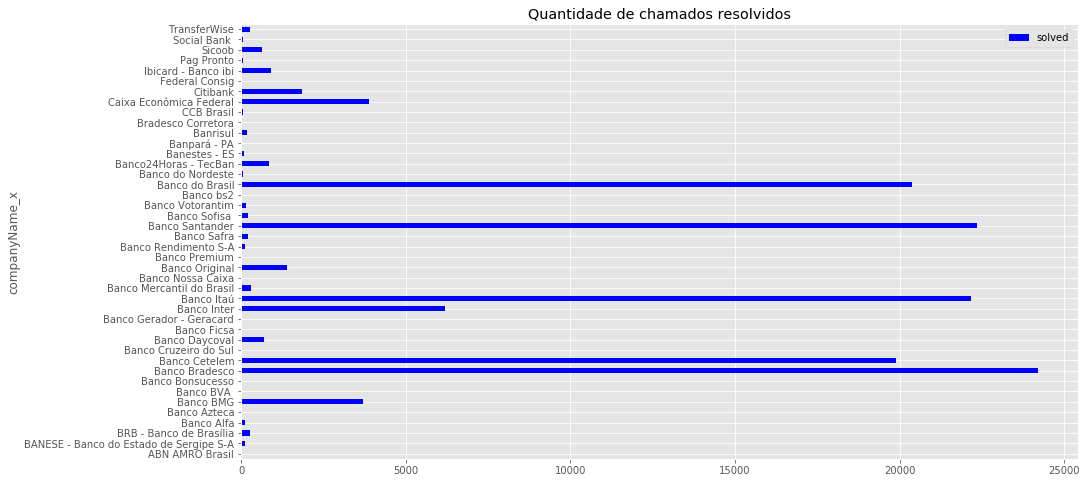

In [0]:
banco_unsolved.plot(figsize=(15,8), kind='barh')
plt.title("Quantidade de chamados não resolvidos")
plt.legend(['Unsolved'])
plt.show()

print('\n')

banco_solved.plot(figsize=(15,8), kind='barh', color='blue')
plt.title("Quantidade de chamados resolvidos")
plt.show()



In [0]:
df_reclamacoes.index

Index(['L_lWpWWSl7kl_qS_', '_80Jzvn7f8WNyKNr', 'EmgR3wMrYN_Qeiqz',
       'xRqCsdh2nWXkbTDk', 'uFk9cGeGy0J3vJQ2', '1zUeaXV7FKsr7xSA',
       'UfDUrpoh1DaWfONX', 'iWwL01xP2nLxkuvB', 'jhCXVEDBk-Cl4eyY',
       'A5xEoRFUX3JEwkB1',
       ...
       'JE1KKm-Lf9LtnRY8', 'Y1zSZwr65c5l02FE', 'VIdIKXVw7HB_6vqv',
       'B8N8ceh6U3mN-YOS', 'swp8Bl6MNpRaSU0n', 'IhwDSXb2HLxHr5Dz',
       'wUD6PnyeXiB8wxoX', 'gn1NvmfCPPzYTDrq', 'aVCSUYrKulmwsFPk',
       'zh4Z5H83LBx6SVl2'],
      dtype='object', name='id', length=188612)

In [0]:
# Criando seleção randomica de amostragem

In [0]:
import random

# Populacao = 188612
# Margem de erro = 3%
# Confiabilidade = 95%
# Numero Amostral = 1062


In [0]:
#Criando amostragem para supervisao, favor nao descomentar!

#csv_supervisao = df_rnk_reclamacao[["evaluation"]].sample(n=1062, random_state=1)
#csv_supervisao[:354].to_csv('gdrive/My Drive/Colab Notebooks/Sentimentos_Supervisionar_p1.csv')
#csv_supervisao[354:708].to_csv('gdrive/My Drive/Colab Notebooks/Sentimentos_Supervisionar_p2.csv')
#csv_supervisao[708:].to_csv('gdrive/My Drive/Colab Notebooks/Sentimentos_Supervisionar_p3.csv')


In [0]:

lexico = pd.read_csv('gdrive/My Drive/Colab Notebooks/NRC-Emotion-Lexicon-PT.csv',sep=',',  encoding='cp1252')

In [0]:
lexico.head()

,"Portuguese (Portugal, Brazil) (pt)",Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,surpresa,0,0,0,0,0,0,0,0,0,0
1,ábaco,0,0,0,0,0,0,0,0,0,1
2,abandono,0,1,0,0,0,1,0,1,0,0
3,abandonado,0,1,1,0,0,1,0,1,0,0
4,abandono,0,1,1,0,0,1,0,1,1,0


In [0]:
lexico = lexico.set_index("Portuguese (Portugal, Brazil) (pt)")

In [0]:
def verifica_null (data, column):
    '''
    Função para verificação de registros nulos ou NaN no data set
    
    data (DataFrame), column(str)
    
    retorna --> quantidade de registros nulos na coluna desejada
    
    '''
    
    
    C = column
    nl = 0
    nl = data[C].isnull().sum()
    
    print("Quantidade de null na coluna: " + C + " " + str(nl))

In [0]:
verifica_null(df_reclamacoes,'evaluation')

Quantidade de null na coluna: evaluation 23


In [0]:
def distribuicao (data) :
    '''
    data(DataFrame) -> bar chart
    
    Função para exibir distribuiçao de campos unicos
    contidos no data set como um todo     
    '''
    
    num_unique_labels = data.apply(pd.Series.nunique)
    
    #plotando valores
    num_unique_labels.plot(kind='bar')
    
    #Nomeando eixos
    plt.xlabel('Colunas do dataset')
    plt.ylabel('Número de registros únicos')
    plt.title('Distribuição de dados únicos do dataset')
    
    plt.show()

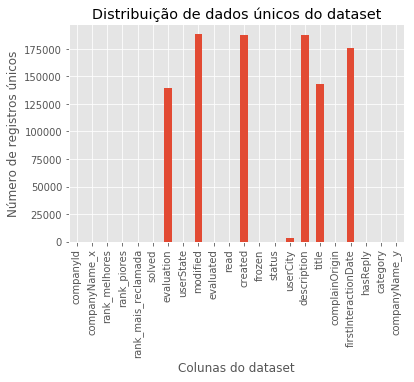

In [0]:
distribuicao(df_reclamacoes)

### Teste do Qui²

In [0]:
def qui_quadrado(data,column):
    
    '''
    data = dataframe
    column (str) = coluna com classes a serem analisadas
    
    Retorna o valor do X², X² crítico, valor do grau de liberdade e do intervalo de confiânça 
    utilizado para o cálculo.
    '''
    
    
    C = column
    
    #Calculando frequencia existente nas classes
    fdist = FreqDist(data[C])
    
    
    #Ajustando contagem e gerando dataframe com os registros    
    dist = pd.DataFrame.from_dict(fdist, orient='index').reset_index().rename(
        columns ={'index':'Classe',0:'Fo'}).sort_values('Classe')
    
    
    # Calculando total de registros da amostragem   
    total_reg = np.sum(dist.Fo)
    #Calculando total de classes distintas
    qtd_classe = (dist.Classe).count()
    #Calculando frequencia esperada
    freq_esp = total_reg/qtd_classe
    
    #Calculando frequencia observada - frequencia esperada
    fo_fe = []
    for i in dist.Fo:
        fo_fe.append(i-freq_esp)    
    dist['f(o)-f(e)'] = fo_fe
    
    
    # Calculando (fo-fe)²    
    fo_fe_sqr = []
    
    for i in dist['f(o)-f(e)']:
        fo_fe_sqr.append(i**2)    
    dist['(fo-fe)²'] = fo_fe_sqr
    
    
    # Retornando (Fo-Fe)² para a forma normal (Normalização numérica), divide-se pela frequencia esperada    
    fo_fe_div = []
    
    for i in dist['(fo-fe)²']:
        fo_fe_div.append(i/freq_esp)    
    dist['(fo-fe)²/fe'] = fo_fe_div
    
    #Calculo do X²    
    qui_sqr = dist['(fo-fe)²/fe'].sum()
    
    
    # Cálculo do grau de liberdade (k=Número de categorias na distribuição da frequencia, gl é o grau de liberdade)
    k = qtd_classe
    gl = k-1
    
    
    # X² crítico (Valores com base na tabela Qui², com significância de 0,05)
    
    if gl == 1:        
        qui_critico = 3.8415
    elif gl == 2:
        qui_critico = 5.9915
    elif gl == 3:
        qui_critico = 7.8147
    elif gl == 4:
        qui_critico = 9.4877
    elif gl == 5:
        qui_critico = 11.0705
    elif gl == 6:
        qui_critico = 12.5916
    elif gl == 7:
        qui_critico = 14.0671
    elif gl == 8:
        qui_critico = 15.5073
    elif gl == 9:
        qui_critico = 16.9190
    elif gl == 10:
        qui_critico = 18.3070
    elif gl == 11:
        qui_critico = 19.6752
    elif gl == 12:
        qui_critico = 21.0261
    elif gl == 13:
        qui_critico = 22.3620
    elif gl == 14:
        qui_critico = 23.6848
    elif gl == 15:
        qui_critico = 24.9958
    elif gl == 16:
        qui_critico = 26.2962
    elif gl == 17:
        qui_critico = 27.5871
    elif gl == 18:
        qui_critico = 28.8693
    elif gl == 19:
        qui_critico = 30.1435
    else:
        qui_critico = 31.4104
            
    
    if qui_sqr > qui_critico:
        print("Grau de significância utilizado 0.050")
        print("Graus de Liberdade: ", gl)        
        print('X² crítico: ',qui_critico )
        print('X²: ',qui_sqr)
        print("Como X² é maior que X² crítico, fica estatísticamente comprovada \n" 
              "a diferença na distribuição de frequência das classes.")
        return(dist)
    else:
        print("Estatisticamente não é comprovada a diferença na distribuição de frequência das classes")
        print("Grau de significância utilizado 0.050")
        print("Graus de Liberdade: ", gl)        
        print('X² crítico: ',qui_critico )
        print('X²: ',qui_sqr)
        print("Como X² é menor que X² crítico, não se comprova estatísticamente\n" 
              "a diferença na distribuição de frequência das classes.")
        return(dist)
    
    
    
    

#### Teste do Qui Quadrado

In [0]:
#qui_quadrado(df_rnk_reclamacao,'description')

### Função de Limpza de dados e Lower case

In [0]:
## Funcao para remocao de numeros, caracteres especiais e stop words
def remove_numerais(data , coluna):
  
  '''
  Esta funcao visa excluir todos os numeros existentes no texto
  
  data(DATAFRAME)
  coluna(STR)
  
  return -> DataFrame
  
  '''
  
  lista = []
  
  try:
    
    lista.extend([ re.sub(r"['0-9']","",str(i)) for i in data[coluna]])

    data[coluna] = lista
    
    return data
  
  except:
    
    KeyError
  
  

def remove_pontuacoes(data, coluna):  
  
  '''
  Esta funcao visa excluir todas as pontuacoes existentes no texto
  Ex: !?;,./
  
  data(DATAFRAME)
  coluna(STR)
  
  return -> DataFrame
  
  '''
    
  lista = []
  
  try:
    
    lista.extend([ re.sub(r'[^\w\s]',"",str(i)) for i in data[coluna]])

    data[coluna] = lista

    return data
  
  except:
    
    KeyError

 
  
def word_to_lowercase(data, coluna):
  
  '''
  Esta funcao visa colocar todas as strings existentes no texto em caixa baixa
  
  data(DATAFRAME)
  coluna(STR)
  
  return -> DataFrame
  
  '''
  
  
  lista = []
  
  
  try:
    
    lista.extend([ str(i).lower() for i in data[coluna]])

    data[coluna] = lista

    return data
  
  except:
    
    KeyError

    
def substituir_palavra_acentuada(data, coluna):
  
  
  '''
  Esta funcao visa remover todas as strings acentuadas no texto 
  
  data(DATAFRAME)
  coluna(STR)
  
  return -> DataFrame
  
  '''
  
  
  lista = [] 
  

  
  data[coluna] = (["".join(re.sub("ó", "o",letra)) for letra in data[coluna]])
  data[coluna] = (["".join(re.sub("ô", "o",letra)) for letra in data[coluna]])
  data[coluna] = (["".join(re.sub("õ", "o",letra)) for letra in data[coluna]])
  data[coluna] = (["".join(re.sub("é", "e",letra)) for letra in data[coluna]])
  data[coluna] = (["".join(re.sub("ê", "e",letra)) for letra in data[coluna]])
  data[coluna] = (["".join(re.sub("í", "i",letra)) for letra in data[coluna]])
  data[coluna] = (["".join(re.sub("ú", "u",letra)) for letra in data[coluna]])
  data[coluna] = (["".join(re.sub("ã", "a",letra)) for letra in data[coluna]])
  data[coluna] = (["".join(re.sub("á", "a",letra)) for letra in data[coluna]])
  data[coluna]= (["".join(re.sub("â", "a",letra)) for letra in data[coluna]])
  data[coluna]= (["".join(re.sub("ç", "c",letra)) for letra in data[coluna]])
  
   
  
  data[coluna]= (["".join(re.sub("menas", "menos",letra)) for letra in data[coluna]])
  data[coluna]= (["".join(re.sub("reselvido", "resolvido",letra)) for letra in data[coluna]])
  
  return data



In [0]:
#Chamando Funcao  
%time df_rnk_reclamacao = remove_numerais(remove_pontuacoes(word_to_lowercase(df_reclamacoes,"evaluation"),"evaluation"),"evaluation")

CPU times: user 1.15 s, sys: 21.9 ms, total: 1.17 s
Wall time: 1.17 s


In [0]:
%time df_rnk_reclamacao = substituir_palavra_acentuada(df_rnk_reclamacao,"evaluation")

CPU times: user 9.81 s, sys: 15.1 ms, total: 9.83 s
Wall time: 9.84 s


In [0]:
len(df_rnk_reclamacao)

188612

In [0]:
#@title Tratando Textos de Abertura das Reclamações


In [0]:
#Chamando Funcao  
%time df_reclama_abertura = remove_numerais(remove_pontuacoes(word_to_lowercase(df_reclamacoes,"description"),"description"),"description")

CPU times: user 5.21 s, sys: 175 ms, total: 5.38 s
Wall time: 5.39 s


In [0]:
%time df_reclama_abertura = substituir_palavra_acentuada(df_reclama_abertura,"description")

CPU times: user 45.9 s, sys: 130 ms, total: 46.1 s
Wall time: 46.1 s


In [0]:
len(df_reclama_abertura)

188612

In [0]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

stopwords = nltk.corpus.stopwords.words('portuguese')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
 stopwords_pt = ["acerca","a","adeus","agora","ainda","alem","algmas","algo","algumas","alguns","ali","além","ambas","ambos","ano","anos","antes",\
                    "ao","aonde","aos","apenas","apoio","apontar","apos","após","aquela","aquelas","aquele","aqueles","aqui","aquilo","as","assim",\
                    "através","atrás","até","aí","baixo","bastante","breve","cada","caminho","catorze","cedo","cento","de"\
                    "certamente","certeza","cima","cinco","coisa","com","como","comprido","conhecido","conselho","contra","contudo","corrente","cuja",\
                    "cujas","cujo","de","cujos","custa","cá","da","daquela","daquelas","daquele","daqueles","dar","das","de","debaixo","dela","delas","dele",\
                    "deles","demais","dentro","depois","desde","desligado","dessa","dessas","desse","desses","desta","destas","deste","destes","deve",\
                    "devem","deverá","dez","dezanove","dezasseis","dezassete","dezoito","dia","diante","direita","dispoe","dispoem","diversa","diversas",\
                    "diversos","diz","dizem","dizer","do","dois","dos","doze","duas","durante","dá","dão","dúvida","e","ela","elas","ele","eles","em",\
                    "embora","enquanto","entao","entre","então","era","eram","essa","essas","esse","esses","esta","estado","estamos","estar","estará",\
                    "estas","estava","estavam","este","esteja","estejam","estejamos","estes","esteve","estive","estivemos","estiver","estivera",\
                    "estiveram","estiverem","estivermos","estivesse","estivessem","estiveste","estivestes","estivéramos","estivéssemos","estou","está",\
                    "estás","estávamos","estão","eu","exemplo","falta","fará","favor","faz","fazeis","fazem","fazemos","fazer","fazes","fazia","faço",\
                    "fez","fim","final","foi","fomos","for","fora","foram","forem","forma","formos","fosse","fossem","foste","fostes","fui","fôramos",\
                    "fôssemos","geral","grande","grandes","grupo","ha","haja","hajam","hajamos","havemos","havia","hei","hoje","hora","horas","houve",\
                    "houvemos","houver","houvera","houveram","houverei","houverem","houveremos","houveria","houveriam","houvermos","houverá","houverão",\
                    "houveríamos","houvesse","houvessem","houvéramos","houvéssemos","há","hão","iniciar","inicio","ir","irá","isso","ista","iste","isto",\
                    "já","lado","lhe","lhes","ligado","local","logo","longe","lugar","lá","maior","maioria","maiorias","mais","mal","mas","me",\
                    "mediante","meio","menor","menos","meses","mesma","mesmas","mesmo","mesmos","meu","meus","mil","minha","minhas","momento","muito",\
                    "muitos","máximo","mês","na","nada","naquela","naquelas","naquele","naqueles","nas","nem","nenhuma","nessa","nessas","nesse",\
                    "nesses","nesta","nestas","neste","nestes","no","noite","nome","nos","nossa","nossas","nosso","nossos","nova","novas","nove","novo",\
                    "novos","num","numa","numas","nunca","nuns","não","nível","nós","número","o","obra","obrigada","obrigado","oitava","oitavo","oito","onde",\
                    "ontem","onze","os","ou","outra","outras","outro","outros","para","parece","parte","partir","paucas","pegar","pela","pelas","pelo",\
                    "pelos","perante","perto","pessoas","pode","podem","poder","poderá","podia","pois","ponto","pontos","por","porque","porquê",\
                    "portanto","posição","possivelmente","posso","possível","pouca","pouco","poucos","povo","primeira","primeiras","primeiro",\
                    "primeiros","promeiro","propios","proprio","própria","próprias","próprio","próprios","próxima","próximas","próximo","próximos",\
                    "puderam","pôde","põe","põem","quais","qual","qualquer","quando","quanto","quarta","quarto","quatro","que","quem","quer","quereis",\
                    "querem","queremas","queres","quero","questão","quieto","quinta","quinto","quinze","quáis","quê","relação","sabe","sabem","saber",\
                    "se","segunda","segundo","sei","seis","seja","sejam","sejamos","sem","sempre","sendo","ser","serei","seremos","seria","seriam",\
                    "será","serão","seríamos","sete","seu","seus","sexta","sexto","sim","sistema","sob","sobre","sois","somente","somos","sou","sua",\
                    "suas","são","sétima","sétimo","só","tal","talvez","tambem","também","tanta","tantas","tanto","tarde","te","tem","temos","tempo",\
                    "tendes","tenha","tenham","tenhamos","tenho","tens","tentar","tentaram","tente","tentei","ter","terceira","terceiro","terei",\
                    "teremos","teria","teriam","terá","terão","teríamos","teu","teus","teve","tinha","tinham","tipo","tive","tivemos","tiver","tivera",\
                    "tiveram","tiverem","tivermos","tivesse","tivessem","tiveste","tivestes","tivéramos","tivéssemos","toda","todas","todo","todos",\
                    "trabalhar","trabalho","treze","três","tu","tua","tuas","tudo","tão","tém","têm","tínhamos","um","uma","umas","uns","usa","usar",\
                    "vai","vais","valor","veja","vem","vens","ver","verdade","verdadeiro","vez","vezes","viagem","vindo","vinte","você",\
                    "vocês","vos","vossa","vossas","wellington","william","windows","vosso","vossos","cliente","vários","vão","vêm","vós","zero","à","às","área","é","éramos","és","último"]
    


In [0]:
tokenize = []


# = nltk.FreqDist(w.lower() for w in floresta.words() if w not in stopwords)

for idx, word in zip(df_rnk_reclamacao.index,df_rnk_reclamacao["evaluation"]):
    
    if word not in stopwords_pt:
        [tokenize.extend( (nltk.word_tokenize(word))), idx] 
        
        
print(len(tokenize))


bagofWords = []

for i in tokenize:
  if i in lexico.index:
    bagofWords.append(i)
    
tokenize = bagofWords


3197441


In [0]:
len(tokenize)

771319

In [0]:
df_reclamacao = df_rnk_reclamacao.copy()

df_rnk_reclamacao = pd.DataFrame(tokenize, columns=["Words"]).merge(lexico, right_on=lexico.index, left_on='Words', how="left").fillna(0)

In [0]:
#Tokenizando textos das aberturas dos incidentes

In [0]:
tokenize = []


# = nltk.FreqDist(w.lower() for w in floresta.words() if w not in stopwords)

for idx, word in zip(df_reclama_abertura.index,df_reclama_abertura["description"]):
    
    if word not in stopwords_pt:
       [tokenize.extend( (nltk.word_tokenize(word))), idx]

print(len(tokenize))
        
bagofWords = []

for i in tokenize:
  if i in lexico.index:
    bagofWords.append(i)
    
tokenize = bagofWords

25072009


In [0]:
len(tokenize)

5667558

In [0]:
df_reclama_abertura = pd.DataFrame(tokenize, columns=["Words"]).merge(lexico, right_on=lexico.index, left_on='Words', how="left").fillna(0)

In [0]:
df_reclama_abertura.head(10)

,Words,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,de,0,0,0,0,0,0,0,0,0,0
1,banco,0,0,0,0,0,0,0,0,0,1
2,banco,0,0,0,0,0,0,0,0,0,0
3,de,0,0,0,0,0,0,0,0,0,0
4,conta,0,0,0,0,0,0,0,0,0,1
5,conta,0,0,0,0,0,0,0,0,0,0
6,conta,0,0,0,0,0,0,0,0,0,1
7,conta,0,0,0,0,0,0,0,0,0,0
8,tarifa,0,0,0,0,0,0,0,0,0,0
9,tarifa,0,1,1,0,1,0,0,0,0,0


In [0]:
positive = df_reclama_abertura.Positive.astype(int).sum()
negative = df_reclama_abertura.Negative.astype(int).sum()
joy = df_reclama_abertura.Joy.astype(int).sum()
anger = df_reclama_abertura.Anger.astype(int).sum()
fear = df_reclama_abertura.Fear.astype(int).sum()
antecipation = df_reclama_abertura.Anticipation.astype(int).sum()
disgust = df_reclama_abertura.Disgust.astype(int).sum()
sadness = df_reclama_abertura.Sadness.astype(int).sum()
surprise = df_reclama_abertura.Surprise.astype(int).sum()
trust = df_reclama_abertura.Trust.astype(int).sum()


resumo = pd.DataFrame([[positive,negative,anger,antecipation,disgust,fear,joy,sadness,surprise,trust]]\
                      ,columns=["Positive","Negative","Anger","Antecipation","Disgust","Fear","Joy","Sadness","Surprise","Trust"])

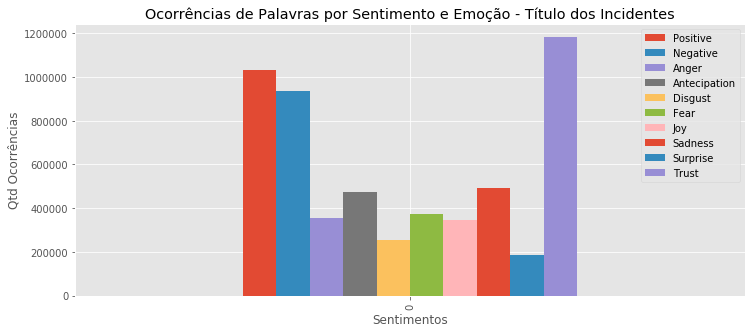

In [0]:
resumo.plot(kind='bar', figsize=(12,5))
plt.ylabel("Qtd Ocorrências")
plt.xlabel("Sentimentos")    
plt.title("Ocorrências de Palavras por Sentimento e Emoção - Título dos Incidentes")
plt.show()

In [0]:
palavras_positivas_trust = df_reclama_abertura[(df_reclama_abertura.Positive=='1') & (df_reclama_abertura.Trust=='1') ]
palavras_positivas_anticipation = df_reclama_abertura[(df_reclama_abertura.Positive=='1') & (df_reclama_abertura.Anticipation=='1') ]
palavras_positivas_joy = df_reclama_abertura[(df_reclama_abertura.Positive=='1') & (df_reclama_abertura.Joy=='1') ]
palavras_positivas_surprise = df_reclama_abertura[(df_reclama_abertura.Positive=='1') & (df_reclama_abertura.Surprise=='1') ]

In [0]:
sentimentos_positivos  = pd.DataFrame([[palavras_positivas_trust["Trust"].values.astype(int).sum()\
                                        ,palavras_positivas_anticipation["Anticipation"].values.astype(int).sum()\
                                        ,palavras_positivas_joy["Joy"].values.astype(int).sum()\
                                        ,palavras_positivas_surprise["Surprise"].values.astype(int).sum()]]\
                      ,columns=["Trust","Antecipation","Joy","Surprise"])

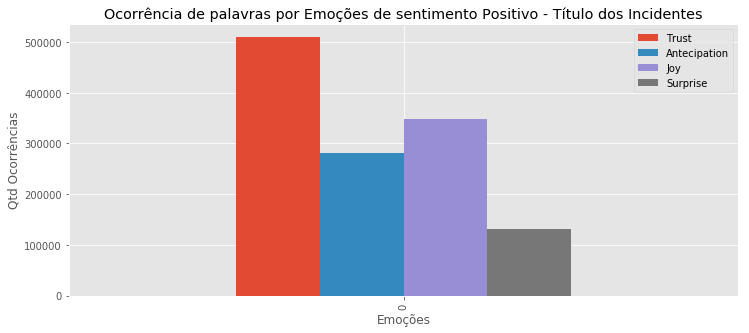

In [0]:
sentimentos_positivos.plot(kind='bar', figsize=(12,5))
plt.ylabel("Qtd Ocorrências")
plt.xlabel("Emoções")    
plt.title("Ocorrência de palavras por Emoções de sentimento Positivo - Título dos Incidentes")
plt.show()

In [0]:
palavras_positivas_trust[["Trust","Positive","Surprise","Joy","Trust"]] = palavras_positivas_trust[["Trust","Positive","Surprise","Joy","Trust"]] .astype(int)

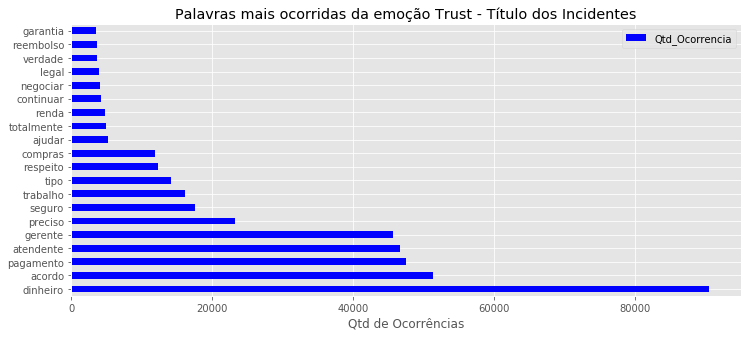

In [0]:
from collections import Counter

pd.DataFrame.from_dict(Counter(palavras_positivas_trust["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5), color='blue')
plt.title("Palavras mais ocorridas da emoção Trust - Título dos Incidentes")
plt.xlabel("Qtd de Ocorrências")
plt.show()

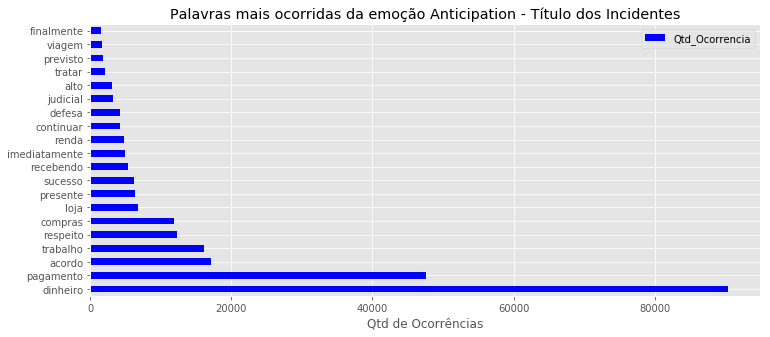

In [0]:
pd.DataFrame.from_dict(Counter(palavras_positivas_anticipation["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color='blue')
plt.title("Palavras mais ocorridas da emoção Anticipation - Título dos Incidentes")
plt.xlabel("Qtd de Ocorrências")
plt.show()

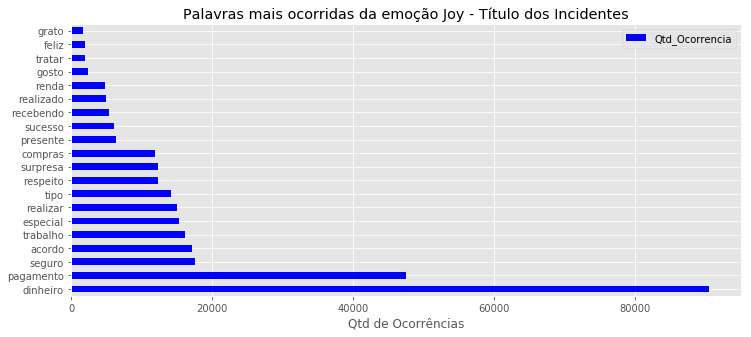

In [0]:
pd.DataFrame.from_dict(Counter(palavras_positivas_joy["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color='blue')
plt.title("Palavras mais ocorridas da emoção Joy - Título dos Incidentes")
plt.xlabel("Qtd de Ocorrências")
plt.show()

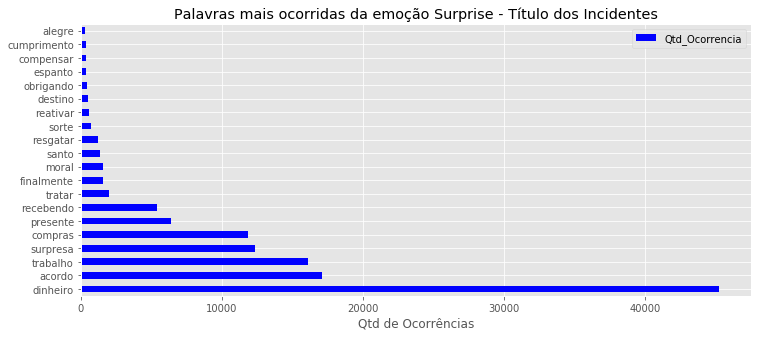

In [0]:
pd.DataFrame.from_dict(Counter(palavras_positivas_surprise["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color='blue')
plt.title("Palavras mais ocorridas da emoção Surprise - Título dos Incidentes")
plt.xlabel("Qtd de Ocorrências")
plt.show()

In [0]:
#@title Análise de Palavras com conotação Negativa


In [0]:
palavras_negativas_anger = df_reclama_abertura[(df_reclama_abertura.Negative=='1') & (df_reclama_abertura.Anger=='1') ]
palavras_negativas_disgust = df_reclama_abertura[(df_reclama_abertura.Negative=='1') & (df_reclama_abertura.Disgust=='1') ]
palavras_negativas_fear= df_reclama_abertura[(df_reclama_abertura.Negative=='1') & (df_reclama_abertura.Fear=='1') ]
palavras_negativas_sadness = df_reclama_abertura[(df_reclama_abertura.Negative=='1') & (df_reclama_abertura.Sadness=='1') ]


In [0]:
sentimentos_negativos  = pd.DataFrame([[palavras_negativas_anger["Anger"].values.astype(int).sum()\
                                        ,palavras_negativas_disgust["Disgust"].values.astype(int).sum()\
                                        ,palavras_negativas_fear["Fear"].values.astype(int).sum()\
                                        ,palavras_negativas_sadness["Sadness"].values.astype(int).sum()]]\
                      ,columns=["Anger","Disgust","Fear","Sadness"])

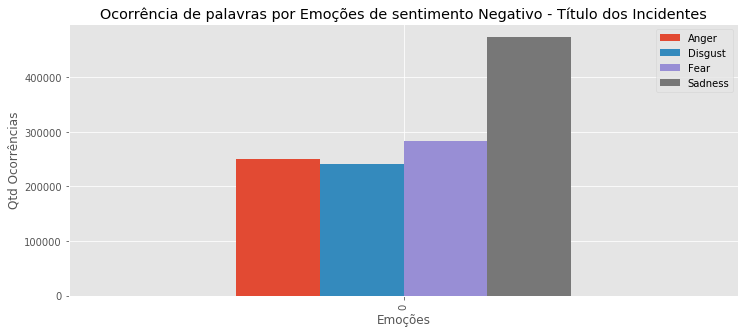

In [0]:
sentimentos_negativos.plot(kind='bar', figsize=(12,5))
plt.ylabel("Qtd Ocorrências")
plt.xlabel("Emoções")    
plt.title("Ocorrência de palavras por Emoções de sentimento Negativo - Título dos Incidentes")
plt.show()

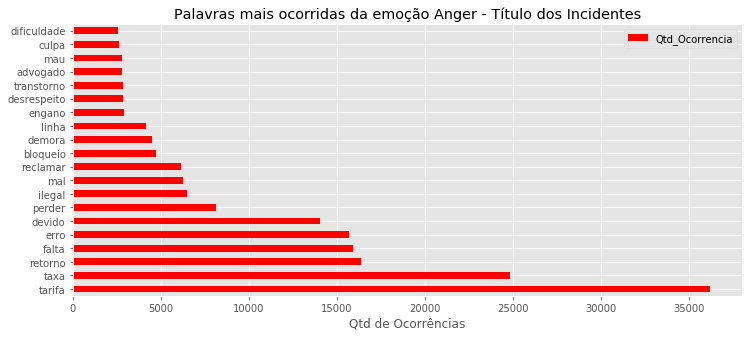

In [0]:
pd.DataFrame.from_dict(Counter(palavras_negativas_anger["Words"]), orient='index'\
                       , columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5), color="red")
plt.title("Palavras mais ocorridas da emoção Anger - Título dos Incidentes")
plt.xlabel("Qtd de Ocorrências")
plt.show()

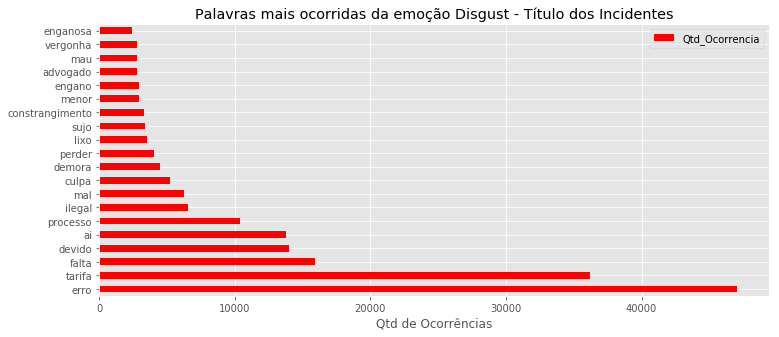

In [0]:
pd.DataFrame.from_dict(Counter(palavras_negativas_disgust["Words"]), orient='index'\
                       , columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color="red")
plt.title("Palavras mais ocorridas da emoção Disgust - Título dos Incidentes")
plt.xlabel("Qtd de Ocorrências")
plt.show()

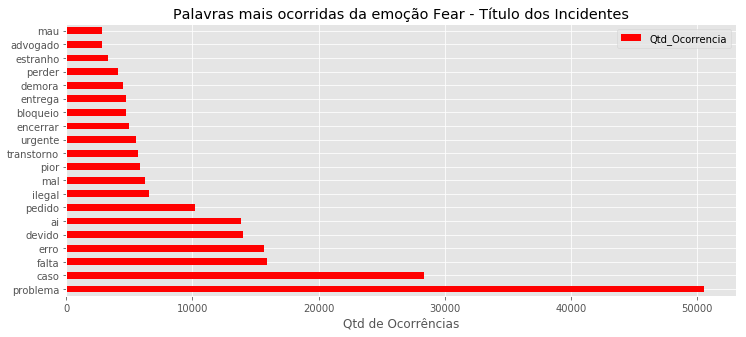

In [0]:
pd.DataFrame.from_dict(Counter(palavras_negativas_fear["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color="red")
plt.title("Palavras mais ocorridas da emoção Fear - Título dos Incidentes")
plt.xlabel("Qtd de Ocorrências")
plt.show()

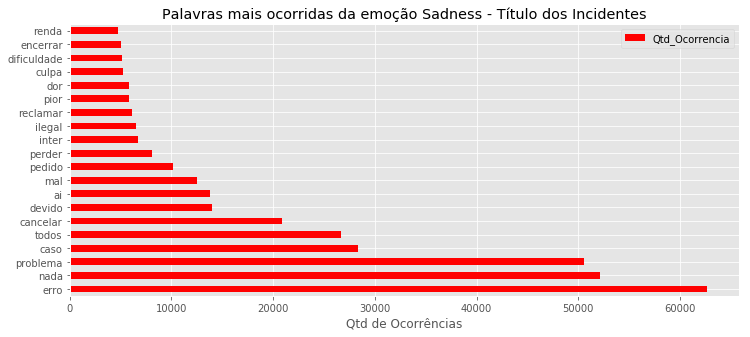

In [0]:
pd.DataFrame.from_dict(Counter(palavras_negativas_sadness["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color="red")
plt.title("Palavras mais ocorridas da emoção Sadness - Título dos Incidentes")
plt.xlabel("Qtd de Ocorrências")
plt.show()

In [0]:
# ANÁLISE DOS RESULTADOS OBTIDOS ENCERRAMENTO

In [0]:
df_rnk_reclamacao.head()

,Words,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,muito,0,0,0,0,0,0,0,0,0,0
1,muito,0,0,0,0,0,0,0,0,0,0
2,bem,1,0,0,0,0,0,0,0,0,0
3,prontamente,1,0,0,0,0,0,0,0,0,0
4,muito,0,0,0,0,0,0,0,0,0,0


In [0]:
positive = df_rnk_reclamacao.Positive.astype(int).sum()
negative = df_rnk_reclamacao.Negative.astype(int).sum()
joy = df_rnk_reclamacao.Joy.astype(int).sum()
anger = df_rnk_reclamacao.Anger.astype(int).sum()
fear = df_rnk_reclamacao.Fear.astype(int).sum()
antecipation = df_rnk_reclamacao.Anticipation.astype(int).sum()
disgust = df_rnk_reclamacao.Disgust.astype(int).sum()
sadness = df_rnk_reclamacao.Sadness.astype(int).sum()
surprise = df_rnk_reclamacao.Surprise.astype(int).sum()
trust = df_rnk_reclamacao.Trust.astype(int).sum()


resumo = pd.DataFrame([[positive,negative,anger,antecipation,disgust,fear,joy,sadness,surprise,trust]]\
                      ,columns=["Positive","Negative","Anger","Antecipation","Disgust","Fear","Joy","Sadness","Surprise","Trust"])

In [0]:
resumo

,Positive,Negative,Anger,Antecipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,162824,159568,46117,58445,36317,83685,42771,106756,19955,143017


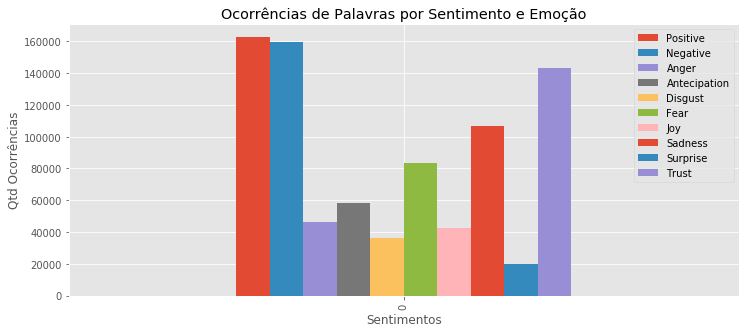

In [0]:
resumo.plot(kind='bar', figsize=(12,5))
plt.ylabel("Qtd Ocorrências")
plt.xlabel("Sentimentos")    
plt.title("Ocorrências de Palavras por Sentimento e Emoção")
plt.show()

In [0]:
palavras_positivas_trust = df_rnk_reclamacao[(df_rnk_reclamacao.Positive=='1') & (df_rnk_reclamacao.Trust=='1') ]
palavras_positivas_anticipation = df_rnk_reclamacao[(df_rnk_reclamacao.Positive=='1') & (df_rnk_reclamacao.Anticipation=='1') ]
palavras_positivas_joy = df_rnk_reclamacao[(df_rnk_reclamacao.Positive=='1') & (df_rnk_reclamacao.Joy=='1') ]
palavras_positivas_surprise = df_rnk_reclamacao[(df_rnk_reclamacao.Positive=='1') & (df_rnk_reclamacao.Surprise=='1') ]


In [0]:
sentimentos_positivos  = pd.DataFrame([[palavras_positivas_trust["Trust"].values.astype(int).sum()\
                                        ,palavras_positivas_anticipation["Anticipation"].values.astype(int).sum()\
                                        ,palavras_positivas_joy["Joy"].values.astype(int).sum()\
                                        ,palavras_positivas_surprise["Surprise"].values.astype(int).sum()]]\
                      ,columns=["Trust","Antecipation","Joy","Surprise"])

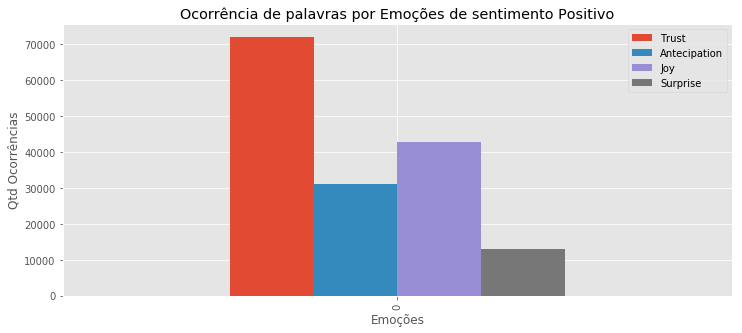

In [0]:
sentimentos_positivos.plot(kind='bar', figsize=(12,5))
plt.ylabel("Qtd Ocorrências")
plt.xlabel("Emoções")    
plt.title("Ocorrência de palavras por Emoções de sentimento Positivo")
plt.show()

In [0]:
palavras_positivas_trust[["Trust","Positive","Surprise","Joy","Trust"]] = palavras_positivas_trust[["Trust","Positive","Surprise","Joy","Trust"]] .astype(int)



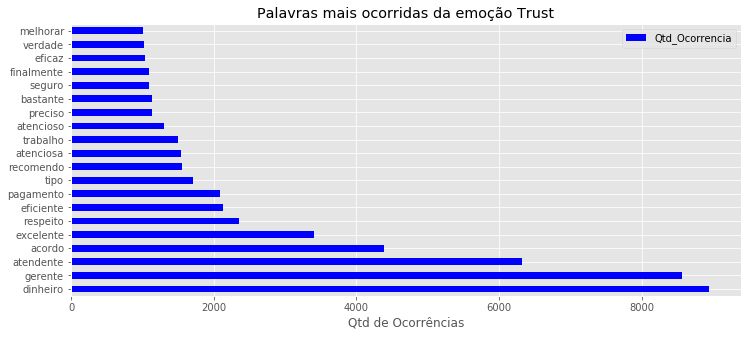

In [0]:
from collections import Counter

pd.DataFrame.from_dict(Counter(palavras_positivas_trust["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color='blue')
plt.title("Palavras mais ocorridas da emoção Trust")
plt.xlabel("Qtd de Ocorrências")
plt.show()

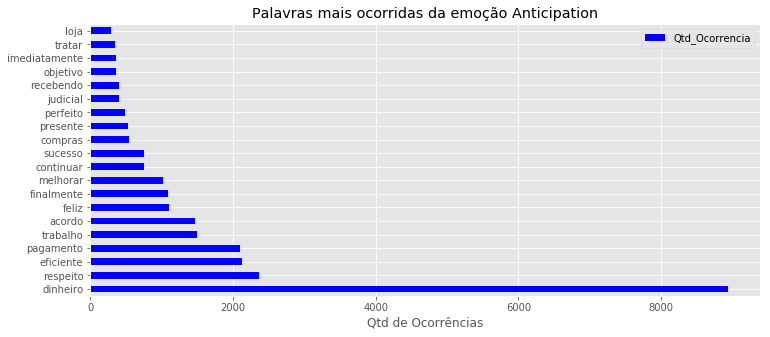

In [0]:

pd.DataFrame.from_dict(Counter(palavras_positivas_anticipation["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color='blue')
plt.title("Palavras mais ocorridas da emoção Anticipation")
plt.xlabel("Qtd de Ocorrências")
plt.show()

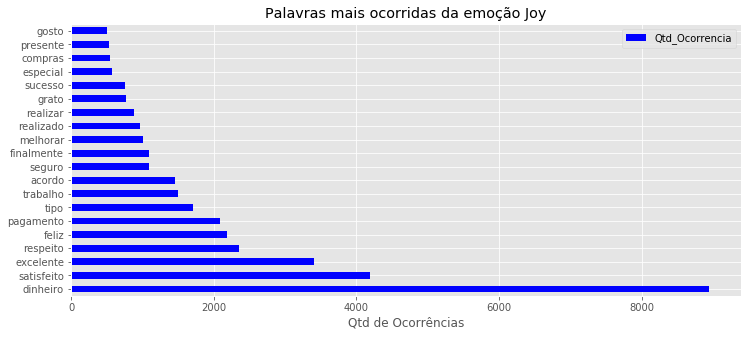

In [0]:

pd.DataFrame.from_dict(Counter(palavras_positivas_joy["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color='blue')
plt.title("Palavras mais ocorridas da emoção Joy")
plt.xlabel("Qtd de Ocorrências")
plt.show()

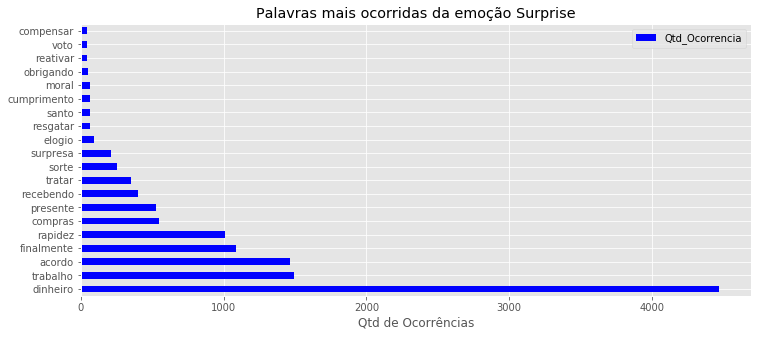

In [0]:

pd.DataFrame.from_dict(Counter(palavras_positivas_surprise["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color='blue')
plt.title("Palavras mais ocorridas da emoção Surprise")
plt.xlabel("Qtd de Ocorrências")
plt.show()

In [0]:
palavras_negativas_anger = df_rnk_reclamacao[(df_rnk_reclamacao.Negative=='1') & (df_rnk_reclamacao.Anger=='1') ]
palavras_negativas_disgust = df_rnk_reclamacao[(df_rnk_reclamacao.Negative=='1') & (df_rnk_reclamacao.Disgust=='1') ]
palavras_negativas_fear= df_rnk_reclamacao[(df_rnk_reclamacao.Negative=='1') & (df_rnk_reclamacao.Fear=='1') ]
palavras_negativas_sadness = df_rnk_reclamacao[(df_rnk_reclamacao.Negative=='1') & (df_rnk_reclamacao.Sadness=='1') ]


In [0]:
sentimentos_negativos  = pd.DataFrame([[palavras_negativas_anger["Anger"].values.astype(int).sum()\
                                        ,palavras_negativas_disgust["Disgust"].values.astype(int).sum()\
                                        ,palavras_negativas_fear["Fear"].values.astype(int).sum()\
                                        ,palavras_negativas_sadness["Sadness"].values.astype(int).sum()]]\
                      ,columns=["Anger","Disgust","Fear","Sadness"])

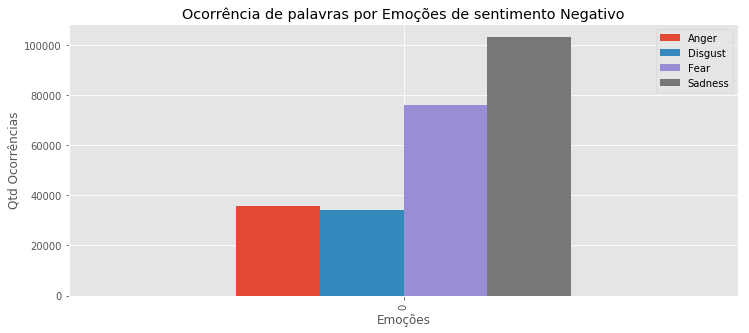

In [0]:
sentimentos_negativos.plot(kind='bar', figsize=(12,5))
plt.ylabel("Qtd Ocorrências")
plt.xlabel("Emoções")    
plt.title("Ocorrência de palavras por Emoções de sentimento Negativo")
plt.show()

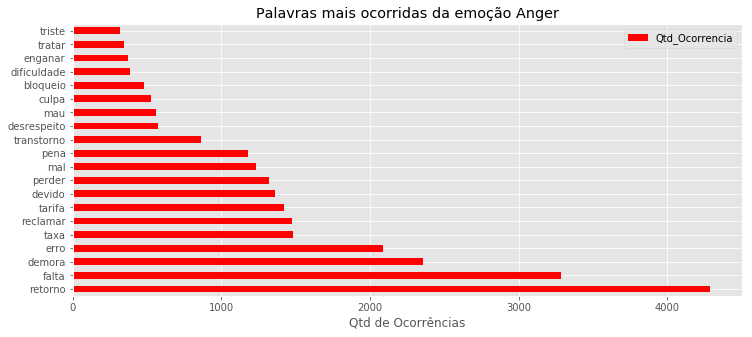

In [0]:

pd.DataFrame.from_dict(Counter(palavras_negativas_anger["Words"]), orient='index'\
                       , columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5), color="red")
plt.title("Palavras mais ocorridas da emoção Anger")
plt.xlabel("Qtd de Ocorrências")
plt.show()

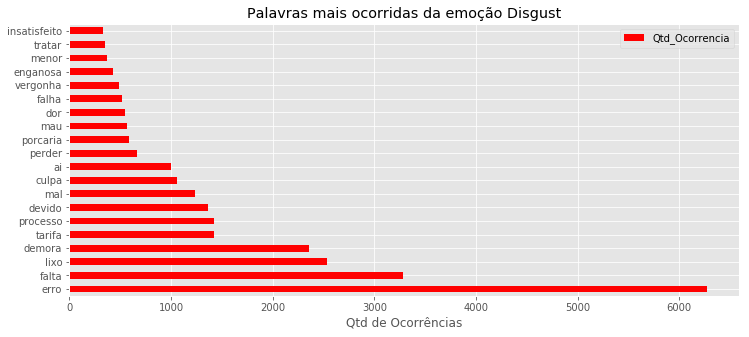

In [0]:
pd.DataFrame.from_dict(Counter(palavras_negativas_disgust["Words"]), orient='index'\
                       , columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color="red")
plt.title("Palavras mais ocorridas da emoção Disgust")
plt.xlabel("Qtd de Ocorrências")
plt.show()

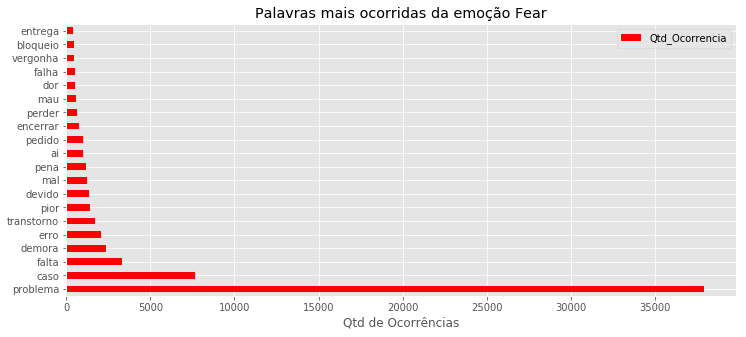

In [0]:
pd.DataFrame.from_dict(Counter(palavras_negativas_fear["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color="red")
plt.title("Palavras mais ocorridas da emoção Fear")
plt.xlabel("Qtd de Ocorrências")
plt.show()

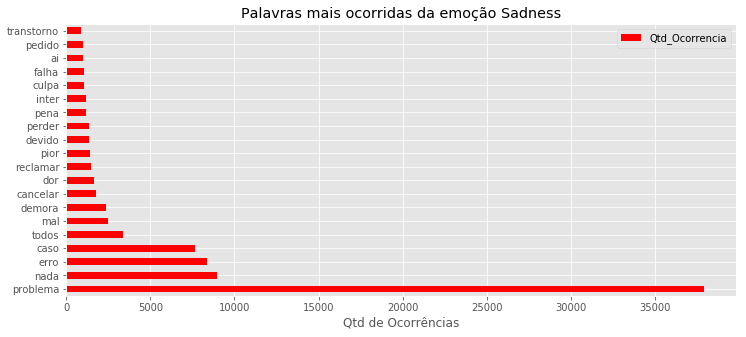

In [0]:
pd.DataFrame.from_dict(Counter(palavras_negativas_sadness["Words"]), orient='index',\
                       columns=["Qtd_Ocorrencia"]).sort_values(ascending=False, by="Qtd_Ocorrencia")[:20]\
.plot(kind="barh", figsize=(12,5),color="red")
plt.title("Palavras mais ocorridas da emoção Sadness")
plt.xlabel("Qtd de Ocorrências")
plt.show()

### Buscador de Termos na sentença

In [0]:
def busca_termo(data,coluna,termo):
    '''
    Função para busca de sentenças que contenham o termo desejado
    
    termo (str) -> sentenças co o termo e a quantidade total de sentenças 
    as quais o termo aparece
    '''
    listagem = []
    
    cnt = 0
    wrd = termo.lower()


    for i,idx in zip(data[coluna],data.index):
        if re.search(r"\b"+wrd,str(i)):
            cnt += 1
            #print(idx,str(i)+'\n',classe)
            listagem.append((idx,str(i)))

    print("Palavra: ",wrd , " ocorreu em " , cnt , " sentenças." + "\n")
    
    return listagem



In [0]:
busca_termo(data=df_reclamacao,coluna='evaluation',termo='bradesco')

Palavra:  bradesco  ocorreu em  3895  sentenças.



[('uFk9cGeGy0J3vJQ2',
  'a pessoa que me atendeu me deu uma dica de usar o aplicativo do bradesco foi resolvido'),
 ('UfDUrpoh1DaWfONX',
  'o problema e que ha alguns anos eu tinha um debito em conta da unimed e pedi para cancelalo agora eu pedi para fazer o debito de outra conta da unimed mas o bradesco recusou estes novos debitos a mensagem enviada para a unimed nao era muito clara sobre o motivo da recusa  na verdade o bradesco tem acordo para fazer debitos da unimed curitiba mas esse debito nao pode ser pedido pelo cliente diretamente usando o internet banking precisa ser comandado diretamente pela unimed  os gerentes do bradesco foram extremamente atenciosos resolveram o problema inclusive em relacao a valores cobrados indevidamente o debito ja esta programado para acontecer dia  aparecendo nos lancamentos futuros'),
 ('A5xEoRFUX3JEwkB1',
  'o cliente comum nao interessa ao bradesco mesmo o cliente antigo'),
 ('yFupWTPVRAAI3wQz',
  'nao ficou claro  realmente os fatos foram ocorri

In [0]:
#Obtendo Amostras Supervisionadas

In [0]:
amostra_sup1 = pd.read_csv('gdrive/My Drive/Colab Notebooks/Sentimentos_Supervisionar_p1.csv')
amostra_sup2 = pd.read_csv('gdrive/My Drive/Colab Notebooks/Sentimentos_Supervisionar_p2.csv')
amostra_sup3 = pd.read_csv('gdrive/My Drive/Colab Notebooks/Sentimentos_Supervisionar_p3.csv')

In [0]:
# amostra_supervisionada = pd.concat((amostra_sup1,amostra_sup2,amostra_sup3))
amostra_supervisionada = (amostra_sup1)

In [0]:
classe_num = []

In [0]:
amostra_supervisionada.head()

,id,evaluation,Classe,Sub_Classe
0,38417626,Desde 2002 cliente deste maldito banco. Fui en...,NEGATIVO,Anger
1,tMHWKAvl6uv0fkeB,"Boa noite, Depois que registrei a reclama nes...",NEUTRO,NEUTRO
2,uO0fWh9SJtGBycI4,Muito bom!,POSITIVO,Joy
3,fCLD0DBK3-nei9iY,Resolveram meu problema.,NEUTRO,NEUTRO
4,Iw0ewR1v-j5iHgiy,resolveu,NEUTRO,NEUTRO


In [0]:
# Aplicando chaves numericas as emocoes NEGATIVO= 0  POSITIVO = 1 NEUTRO = 2

for i in amostra_supervisionada['Classe']:
  if i == "NEGATIVO":
    classe_num.append(0)
  elif i == "POSITIVO":
    classe_num.append(1)
  else:
    classe_num.append(2)

In [0]:
amostra_supervisionada["Classe_num"] = classe_num

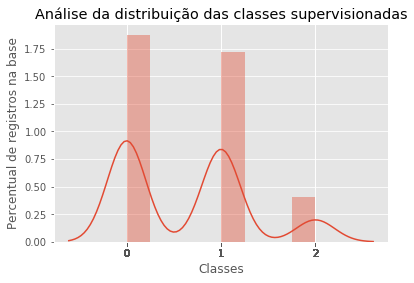

In [0]:
def dist_class(data, column, x_titulo,y_titulo,chart_titulo):
    
    '''
     Visa apresentar a distribuição de registros existentes em uma coluna específica
    
    data (DataFrame), column (STR) -> NOME DA COLUNA, x_titulo (STR) -> Título do eixo X
    y_titulo (str) -> Título do eixo y, chart_titulo (str) -> Título principal do gráfico
    
    retorna gráfico de distribuição
    
    
    '''
    #label = {'0':"NEGATIVO",'1':"POSITIVO",'2':"NEUTRO"}
    
    C = column

    sns.distplot(data[C])
    plt.xlabel(x_titulo)    
    plt.ylabel(y_titulo)
    plt.xticks(data[C])
    plt.title(chart_titulo)
    plt.show()

dist_class(amostra_supervisionada, 'Classe_num', 'Classes','Percentual de registros na base','Análise da distribuição das classes supervisionadas')

In [0]:
#PRE PROCESSAMENTO DA AMOSTRAGEM

In [0]:
#Chamando Funcao  
%time amostra_supervisionada = remove_numerais(remove_pontuacoes(word_to_lowercase(amostra_supervisionada,"evaluation"),"evaluation"),"evaluation")

CPU times: user 4.9 ms, sys: 0 ns, total: 4.9 ms
Wall time: 4.92 ms


In [0]:
%time amostra_supervisionada = substituir_palavra_acentuada(amostra_supervisionada,"evaluation")

CPU times: user 28 ms, sys: 1 ms, total: 29 ms
Wall time: 50.3 ms


#### Separando features para o Modelo


In [0]:
'''# SEPARANDO AS VARIÁVEIS DE ANÁLISE #equipe_solucionador'''
#Variáveis independentes
X = amostra_supervisionada['evaluation']  

#Variavel dependente
y = amostra_supervisionada['Classe_num']


In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.33 )

## Criando Processo de TF/IDF

#### Inicializando TF IDF Vectorizer

In [0]:
def text_frequency_idf(X_train,X_test):
    
    '''
    Função que cria o processo de Text Frequency e Inverse document Frequency
    Visa contar e aplicar o resultado da contagem de frequencia da palavra a um cálculo
    de média logaritimica, para aplicar peso aos termos(palavras) contidos nas sentenças existentes no dataset
    
    Xtrain (X_train), Xtest (Xtest) --> tfidf_train, tidf_test
    
  '''
    
    stopwords_pt = ["acerca","adeus","agora","ainda","alem","algmas","algo","algumas","alguns","ali","além","ambas","ambos","ano","anos","antes",\
                    "ao","aonde","aos","apenas","apoio","apontar","apos","após","aquela","aquelas","aquele","aqueles","aqui","aquilo","as","assim",\
                    "através","atrás","até","aí","baixo","bastante","breve","cada","caminho","catorze","cedo","cento",\
                    "certamente","certeza","cima","cinco","coisa","com","como","comprido","conhecido","conselho","contra","contudo","corrente","cuja",\
                    "cujas","cujo","cujos","custa","cá","da","daquela","daquelas","daquele","daqueles","dar","das","de","debaixo","dela","delas","dele",\
                    "deles","demais","dentro","depois","desde","desligado","dessa","dessas","desse","desses","desta","destas","deste","destes","deve",\
                    "devem","deverá","dez","dezanove","dezasseis","dezassete","dezoito","dia","diante","direita","dispoe","dispoem","diversa","diversas",\
                    "diversos","diz","dizem","dizer","do","dois","dos","doze","duas","durante","dá","dão","dúvida","e","ela","elas","ele","eles","em",\
                    "embora","enquanto","entao","entre","então","era","eram","essa","essas","esse","esses","esta","estado","estamos","estar","estará",\
                    "estas","estava","estavam","este","esteja","estejam","estejamos","estes","esteve","estive","estivemos","estiver","estivera",\
                    "estiveram","estiverem","estivermos","estivesse","estivessem","estiveste","estivestes","estivéramos","estivéssemos","estou","está",\
                    "estás","estávamos","estão","eu","exemplo","falta","fará","favor","faz","fazeis","fazem","fazemos","fazer","fazes","fazia","faço",\
                    "fez","fim","final","foi","fomos","for","fora","foram","forem","forma","formos","fosse","fossem","foste","fostes","fui","fôramos",\
                    "fôssemos","geral","grande","grandes","grupo","ha","haja","hajam","hajamos","havemos","havia","hei","hoje","hora","horas","houve",\
                    "houvemos","houver","houvera","houveram","houverei","houverem","houveremos","houveria","houveriam","houvermos","houverá","houverão",\
                    "houveríamos","houvesse","houvessem","houvéramos","houvéssemos","há","hão","iniciar","inicio","ir","irá","isso","ista","iste","isto",\
                    "já","lado","lhe","lhes","ligado","local","logo","longe","lugar","lá","maior","maioria","maiorias","mais","mal","mas","me",\
                    "mediante","meio","menor","menos","meses","mesma","mesmas","mesmo","mesmos","meu","meus","mil","minha","minhas","momento","muito",\
                    "muitos","máximo","mês","na","nada","naquela","naquelas","naquele","naqueles","nas","nem","nenhuma","nessa","nessas","nesse",\
                    "nesses","nesta","nestas","neste","nestes","no","noite","nome","nos","nossa","nossas","nosso","nossos","nova","novas","nove","novo",\
                    "novos","num","numa","numas","nunca","nuns","não","nível","nós","número","o","obra","obrigada","obrigado","oitava","oitavo","oito","onde",\
                    "ontem","onze","os","ou","outra","outras","outro","outros","para","parece","parte","partir","paucas","pegar","pela","pelas","pelo",\
                    "pelos","perante","perto","pessoas","pode","podem","poder","poderá","podia","pois","ponto","pontos","por","porque","porquê",\
                    "portanto","posição","possivelmente","posso","possível","pouca","pouco","poucos","povo","primeira","primeiras","primeiro",\
                    "primeiros","promeiro","propios","proprio","própria","próprias","próprio","próprios","próxima","próximas","próximo","próximos",\
                    "puderam","pôde","põe","põem","quais","qual","qualquer","quando","quanto","quarta","quarto","quatro","que","quem","quer","quereis",\
                    "querem","queremas","queres","quero","questão","quieto","quinta","quinto","quinze","quáis","quê","relação","sabe","sabem","saber",\
                    "se","segunda","segundo","sei","seis","seja","sejam","sejamos","sem","sempre","sendo","ser","serei","seremos","seria","seriam",\
                    "será","serão","seríamos","sete","seu","seus","sexta","sexto","sim","sistema","sob","sobre","sois","somente","somos","sou","sua",\
                    "suas","são","sétima","sétimo","só","tal","talvez","tambem","também","tanta","tantas","tanto","tarde","te","tem","temos","tempo",\
                    "tendes","tenha","tenham","tenhamos","tenho","tens","tentar","tentaram","tente","tentei","ter","terceira","terceiro","terei",\
                    "teremos","teria","teriam","terá","terão","teríamos","teu","teus","teve","tinha","tinham","tipo","tive","tivemos","tiver","tivera",\
                    "tiveram","tiverem","tivermos","tivesse","tivessem","tiveste","tivestes","tivéramos","tivéssemos","toda","todas","todo","todos",\
                    "trabalhar","trabalho","treze","três","tu","tua","tuas","tudo","tão","tém","têm","tínhamos","um","uma","umas","uns","usa","usar",\
                    "vai","vais","valor","veja","vem","vens","ver","verdade","verdadeiro","vez","vezes","viagem","vindo","vinte","você",\
                    "vocês","vos","vossa","vossas","wellington","william","windows","vosso","vossos","cliente","vários","vão","vêm","vós","zero","à","às","área","é","éramos","és","último"]
    
    
    #PROCESSO DE TFIDF QUE SERÁ UTILIZADA NO MODELO DE APRENDIZADO    
    tf_idf = TfidfVectorizer(stop_words=stopwords_pt,ngram_range=(1,3),  min_df=2)
    
    #Treinamento
    tfidf_train = tf_idf.fit_transform(X_train)
    #Teste
    tfidf_test = tf_idf.transform(X_test)
    
    #Verificando Registros
    #print(tf_idf.get_feature_names()[:10])
    
    tfidf_df = pd.DataFrame(tfidf_train.A,columns = tf_idf.get_feature_names())
    
    #print( tfidf_df.sort_values(['data'], ascending=[0]) )
    
    
    return (tfidf_train,tfidf_test,tf_idf,tfidf_df)   
    
    
    

In [0]:
%time tfidf_train, tfidf_test, tf_idf,tfidf_df = text_frequency_idf(X_train, X_test)

CPU times: user 29.3 ms, sys: 63 µs, total: 29.3 ms
Wall time: 33.2 ms


In [0]:
amostra_supervisionada[['Classe','Classe_num']].drop_duplicates().sort_values('Classe_num')

,Classe,Classe_num
0,NEGATIVO,0
2,POSITIVO,1
1,NEUTRO,2


### Buscando Palavras mais correlacionadas com cada classe

In [0]:
def palavras_correlacionadas(X,tf_idf,qtd_palavra):
    
    from sklearn.feature_selection import chi2
    
    
    features = tf_idf.fit_transform(X).toarray()
    labels = amostra_supervisionada.Classe_num


    categoria_df = amostra_supervisionada[['Classe_num','Classe']].drop_duplicates().sort_values('Classe_num')
    categoria_to_id = dict(categoria_df.values)
    id_to_category = dict(categoria_df[['Classe_num','Classe']].values)
    N = qtd_palavra

    '''
    print(categoria_df,'\n')
    print(categoria_to_id,'\n')
    print(id_to_category)
    '''

    for Classe, Product in sorted(categoria_to_id.items()):
        features_chi2 = chi2(features, labels == Classe)

        indices = np.argsort(features_chi2[0])
        features_names = np.array(tf_idf.get_feature_names()) [indices]

        unigrams = [v for v in features_names if len(v.split(' ')) == 1]
        bigrams = [v for v in features_names if len(v.split(' ')) == 2]
        trigrams = [v for v in features_names if len(v.split(' ')) == 3]

        print("# '{}':".format(Product))
        print(".Palavras Mais correlacionadas unigrams:\n. {}".format('\n.'.join(unigrams[-N:])),'\n')    

        print(".Palavras Mais correlacionadas bigrams:\n. {}".format('\n.'.join(bigrams[-N:])),'\n')    

        print(".Palavras Mais correlacionadas trigrams:\n. {}".format('\n.'.join(trigrams[-N:])),'\n')

        print('==============================================================')
    

    

In [0]:
palavras_correlacionadas(X,tf_idf,qtd_palavra= 10)

# 'NEGATIVO':
.Palavras Mais correlacionadas unigrams:
. ruim
.descaso
.excelente
.banco
.rapido
.ok
.resolvido
.nao
.bom
.pessimo 

.Palavras Mais correlacionadas bigrams:
. resolvido prazo
.atendimento rapido
.otimo atendimento
.conta banco
.excelente atendimento
.banco nao
.resolver problema
.nao resolvido
.pessimo atendimento
.problema resolvido 

.Palavras Mais correlacionadas trigrams:
. consegui falar atendente
.entrou contato comigo
.sucesso resolucao problema
.cartao nao chegou
.caixa eletronico agencia
.problema nao solucionado
.ate resolvido problema
.problema nao resolvido
.consegui resolver problema
.nao resolveu problema 

# 'POSITIVO':
.Palavras Mais correlacionadas unigrams:
. descaso
.rapidamente
.agradeco
.ok
.otimo
.nao
.excelente
.rapido
.pessimo
.bom 

.Palavras Mais correlacionadas bigrams:
. resolvido problema
.atendimento excelente
.nao resolvido
.resolvido otimo
.pessimo atendimento
.resolvido prazo
.atendimento rapido
.otimo atendimento
.excelente atendimento


### Gráfico para analise de learning rate

In [0]:
def plot_learning_curve(estimador,titulo, X, y, ylim=None , cv=None, n_jobs=None, train_sizes=np.linspace(.1,1.0,5)):
    
    '''
    Exibindo gráfico da curva de aprendizado 
    de train e do teste    
    '''

    
    plt.figure()
    plt.title(titulo)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Exemplos de Teste")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores= learning_curve(
        estimador, X, y, cv=cv, n_jobs= n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.0, color='g')
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.0, color='r')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross Validation Score')    
    plt.legend(loc='best')
    print("\n")
        
    return plt   
    
    

### Criando função da Curva de Validação

In [0]:
def curva_validação(estimador, X, y,nome_param, param_range,cv, score_name, n_jobs ):
    
    
    train_scores,test_scores = validation_curve( estimador, X,y, param_name=nome_param, param_range=param_range,
                                               cv=cv, scoring=score_name, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores,axis=1 )
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.title("Curva e Validação")
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0,1.1)
    lw=2
    
    plt.semilogx(param_range, train_scores_mean, label='Training score',
                color='darkorange', lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.2,
                        color='darkorange', lw=lw)
    plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
                    color='navy', lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.2,
                        color='navy', lw=lw)
    plt.legend(loc='best')
    print("\n")
   
    
    return plt
    

### Criando função para curva ROC/AUC

In [0]:
def roc_auc(teste,predict,n_classes):
       
    fpr= dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    
    teste = label_binarize(teste,classes=[1,2,3])
    predict = label_binarize(predict,classes=[1,2,3])
    
    for i in range(n_classes):
            
        fpr[i],tpr[i],_ = metrics.roc_curve(teste[:,i],predict[:,i])
        roc_auc[i] = metrics.auc(fpr[i],tpr[i])
        
    #computando micro e macro average
    fpr['micro'], tpr['micro'], _ = metrics.roc_curve(teste.ravel(),predict.ravel())
    roc_auc['micro'] = metrics.auc(fpr["micro"], tpr["micro"])
        
    # Agregando todos os falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    #Interpolando todos os pontos das curvas ROC
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    # Finalmente Average das interpolações e calculo da curva ROC
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"],tpr["macro"])
    
    #Plot all ROC curves
    plt.figure(figsize=[10,8])
    plt.plot(fpr["micro"], tpr["micro"], label='micro average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc['micro']), color='deeppink', linestyle=':', linewidth=4 )
    
    plt.plot(fpr["macro"], tpr["macro"], label='macro average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc['macro']), color='navy', linestyle=':', linewidth=4 )
    
    
    colors = cycle(['aqua','darkorange','cornflowerblue','blue','black','grey','red','purple','skyblue','yellow','pink'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='Curva ROC da classes {0} (area = {1:0.2f})'
                ''.format(i,roc_auc[i]))
        
    
    plt.plot([0,1], [0,1], 'k--', lw=lw)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('Receive Operating Characteristic (ROC) to multi-class')
    plt.legend(loc='lower right')
    plt.show()
    print("\n")

    
    
    

### Criando Heatmap chart para análise da matriz confusa

In [0]:

def confusion_report(ytest, predicao):
    
    '''
    Função para apresentar relatório do classificador
    Exibe a matrix confusa como heatmap (mapa de calor)
    ACCURACY,F1_SCORE, PRECISION e RECALL
    
    '''
    
    y_test = ytest
    pred = predicao
    
    # Chamando método de validação do modelo, relatório de status (accurcy, f1-score,precision,recall)
    score = metrics.classification_report(y_test, pred, target_names=categorias)
    accuracy = metrics.accuracy_score(y_test, pred)
    
    #CONFUSION MATRIX
    cm = metrics.confusion_matrix(y_test,pred)
    #CHART
    f,ax = plt.subplots(figsize=(10,5))
    sns.heatmap(cm, annot=True, linewidths=.5, ax=ax, cmap='Blues_r')
    plt.title('Matriz Confusa\n')
    plt.show()


    print("Accuracy = TP+TN/TP+FP+FN+TN\n" + "Valor: " + str(accuracy))
    print("Precision = TP/TP+FP\n")
    print("Recall = TP/TP+FN\n")
    print("F1 Score = 2*(Recall * Precision) / (Recall + Precision)\n")
    print(score)

#### Função Para Gráfico do Hiperplano

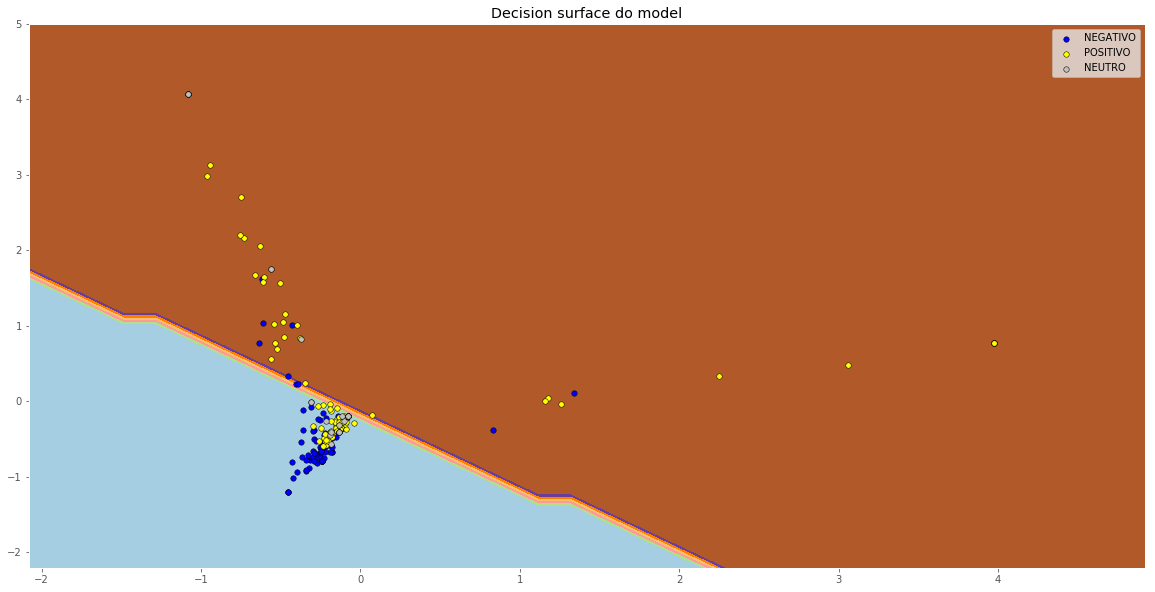

In [0]:
from sklearn.decomposition import PCA
from sklearn import datasets
from matplotlib import colors as cl

pca = PCA(n_components=2)

X_2 = pca.fit_transform(tfidf_train.A)
Y_2 = np.array(y_train)


categorias = ["NEGATIVO","POSITIVO","NEUTRO"]


colors =['#0000FF','#FFFF00','#C0C0C0']


#Shuffle
idx = np.arange(X_2.shape[0])
np.random.seed(3)
np.random.shuffle(idx)

X_2 = X_2[idx]
Y_2 = Y_2[idx]


#Standardize    
mean =  X_2.mean(axis=0)
std = X_2.std(axis=0)

X_2 = (X_2 - mean) / std

h = .2 #passo para tamanho da mesh grid

clf = SGDClassifier(alpha= 0.0001, average= False, class_weight= None,
                        epsilon= 0.1, eta0=1e-8+28762875276.5, fit_intercept= True, l1_ratio= 0.15,
                        learning_rate= 'optimal', loss= 'log', max_iter= 100,  n_jobs=2,
                        penalty= 'l1', power_t= 0.5, random_state=166 , shuffle=True, tol= None,
                        verbose= 0, warm_start= False).fit(X_2,Y_2)


#Criando mesh para plotar
x_min, x_max = X_2[:,0].min() - 1, X_2[:,0].max() + 1
y_min, y_max = X_2[:,1].min() - 1, X_2[:,1].max() + 1


xx, yy = np.meshgrid(np.arange(x_min,x_max, h),
                    np.arange(y_min, y_max, h)
                   )
plt.figure(figsize=(20,10))

#Plot the decision boundary. For that, we will assign a color to each one
#point in the mesh [x_min, x_max]x[y_min,y_max]

Z =  clf.predict(np.c_[xx.ravel(), yy.ravel()])
#Colocando o resultado em sua respectiva cor
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap = plt.cm.Paired)
plt.axis('tight')



#Plotando também os pontos de treinamento

for i, color in zip(clf.classes_   , colors):
    
    idx= np.where(Y_2 == i)
    
    
    plt.scatter(X_2[idx,0], X_2[idx,1], c=color, label=categorias[i],
               cmap=plt.cm.Paired, edgecolor='black', s=30)

    plt.title("Decision surface do model")
    plt.axis('tight')
    plt.legend()
        
    
def plot_hyperplane(c,color):
    def line(x0):
        return (-(x0 * coef[c,0]) - intercept[c]) / coef[c,1]

        plt.plot([x_min,x_max], [line(x_min), line(x_max)],
                ls="--", color=color)


for a, color in zip(clf.classes_, colors):
    plot_hyperplane(a, color)
   
    plt.show()
        

## Criando Modelo de ML

#### Modelo Naive Bayes, distribuição Multinomial

In [0]:
alphas = np.arange(0,1,.1)
categorias = ["NEGATIVO","POSITIVO","NEUTRO"]

def nb_multinomial(alphas,xtrain,xtest, n_classes):
    '''' Função para atribuir diferentes valores de alpha
       ' Ocorrerá o fit do modelo e a predição dos resultados
    '''
        
    xtrain = xtrain
    xtest = xtest
    
    #Chamada do algorítimo MultinomialNB
    nb_classificador = OneVsRestClassifier(MultinomialNB(alpha=alphas))
    
    #Chamando função para gráfico de aprendizado
    titulo = 'Curva de Aprendizado MultinomialNB'
    print("\n")
    plot_learning_curve(nb_classificador, titulo, xtrain, y_train, ylim=(0.0,1.01), cv=5, n_jobs=4 )
    print("\n")
       
    # Fit dos dados de treinamento, para ensinamento da maquina
    %time nb_classificador.fit(xtrain, y_train)
    
    #Chamando classe predict para averiguação dos dados de teste
    pred = nb_classificador.predict(xtest)
    
    print("\n")
    roc_auc(y_test, pred, n_classes)
    
    print("\n")
   
    # OBTENDO DADOS CLASSIFICADOS DE FORMA ERRADA

    result_false = X_test[y_test != pred]
    y_erro = y_test[y_test != pred]
    pred_erro = (pred[y_test != pred])
    err = pd.concat([result_false,y_erro], axis=1).rename(columns={0:'DESCRICAO'})
    predict = []

    for i in pred_erro:
        predict.append(i)

    err['PREDICAO'] = predict

    #err.to_csv("N:/Restrita/sala/predictors/Dados/classificacoes_erradas_MultinomialNB.csv", sep=';', index=True)
    

    
    # Gráfico para exibição das classes em predição 
    
    sns.distplot(y_train, color='red')
    sns.distplot(pred)
    plt.title('\n Distribuição da classificação entre as classes')
    plt.xlabel('Classes')
    plt.ylabel('Quantidade')
    plt.show()
    print("\n")
    confusion_report(ytest=y_test, predicao=pred)

#### Modelo executando sobre TFIDF

Alpha:  0.2






CPU times: user 5.8 ms, sys: 0 ns, total: 5.8 ms
Wall time: 5.81 ms




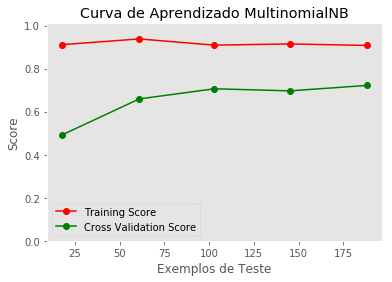

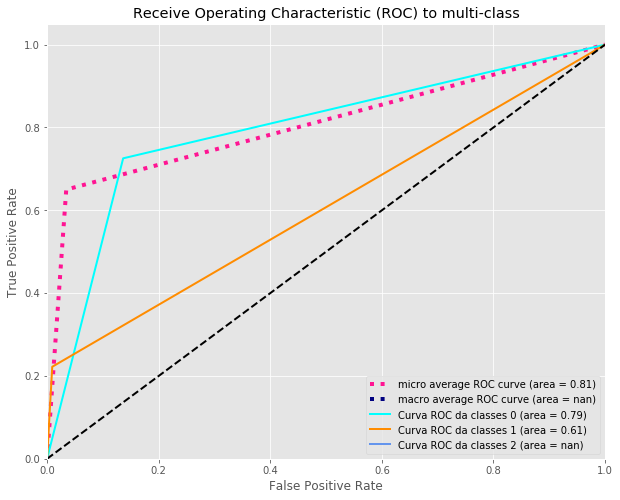

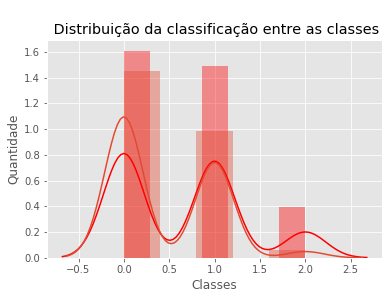

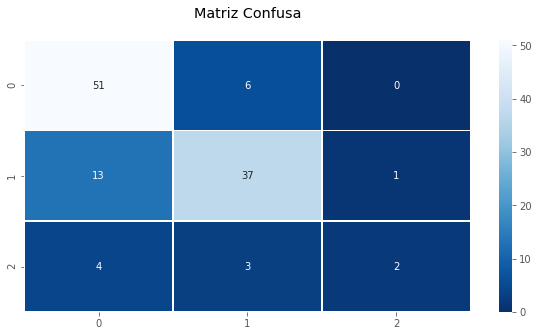

Accuracy = TP+TN/TP+FP+FN+TN
Valor: 0.7692307692307693
Precision = TP/TP+FP

Recall = TP/TP+FN

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

              precision    recall  f1-score   support

    NEGATIVO       0.75      0.89      0.82        57
    POSITIVO       0.80      0.73      0.76        51
      NEUTRO       0.67      0.22      0.33         9

    accuracy                           0.77       117
   macro avg       0.74      0.61      0.64       117
weighted avg       0.77      0.77      0.76       117

Score: None


In [0]:

# Chamando função passando dados do TFIDF
'''
for a in alphas:
    print('Alpha: ' , a)
    print('Score: ' , nb_multinomial(a,tfidf_train,tfidf_test, param_range, n_classes =3))

''' 
print('Alpha: ' , 0.2)
score = nb_multinomial(0.2,tfidf_train,tfidf_test,  n_classes =3)
print('Score:' ,score )



# Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:

clf = RandomForestClassifier(n_estimators=240, criterion='entropy',max_features='log2', max_depth=2000)



CPU times: user 339 ms, sys: 2.04 ms, total: 341 ms
Wall time: 346 ms


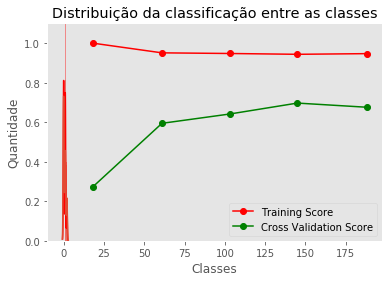

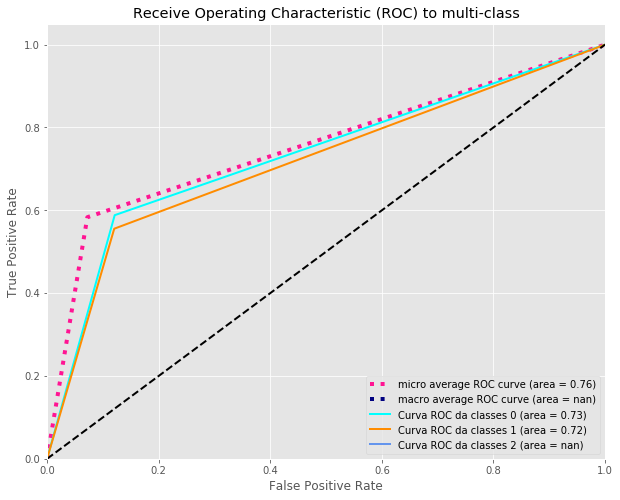

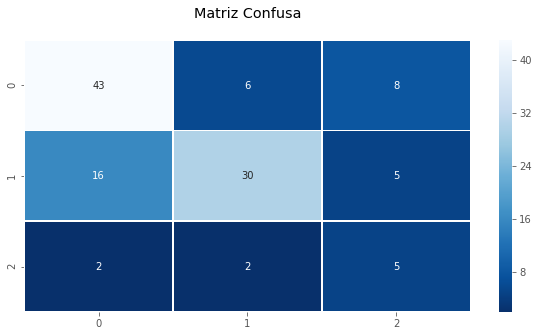

Accuracy = TP+TN/TP+FP+FN+TN
Valor: 0.6666666666666666
Precision = TP/TP+FP

Recall = TP/TP+FN

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

              precision    recall  f1-score   support

    NEGATIVO       0.70      0.75      0.73        57
    POSITIVO       0.79      0.59      0.67        51
      NEUTRO       0.28      0.56      0.37         9

    accuracy                           0.67       117
   macro avg       0.59      0.63      0.59       117
weighted avg       0.71      0.67      0.68       117





In [0]:
plot_learning_curve(clf, 'titulo', tfidf_train, y_train, ylim=(0.0,1.1), cv=5, n_jobs=-1 )


# Fit dos dados de treinamento, para ensinamento da maquina
%time clf.fit(tfidf_train, y_train)
    
#Chamando classe predict para averiguação dos dados de teste
pred = clf.predict(tfidf_test)

    
# Gráfico para exibição das classes em predição    
sns.distplot(y_train, color='red')
sns.distplot(pred)
plt.title('Distribuição da classificação entre as classes')
plt.xlabel('Classes')
plt.ylabel('Quantidade')
plt.show()  
print("\n")

roc_auc(y_test, pred, n_classes=3)
print("\n")
confusion_report(ytest=y_test, predicao=pred)
print("\n")


### SVC Classifier

In [0]:
from sklearn.svm import SVC

In [0]:
clf = SVC(C=1.009, kernel='linear', degree=3, gamma='scale', coef0=1.5, shrinking=True, probability=False,
         tol=0.0001, class_weight='balanced', verbose=False, max_iter=-1,
         decision_function_shape='ovo', random_state=None)



CPU times: user 7.81 ms, sys: 0 ns, total: 7.81 ms
Wall time: 8.72 ms


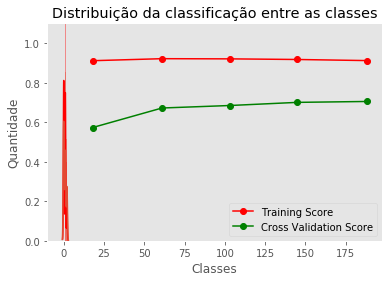

/n


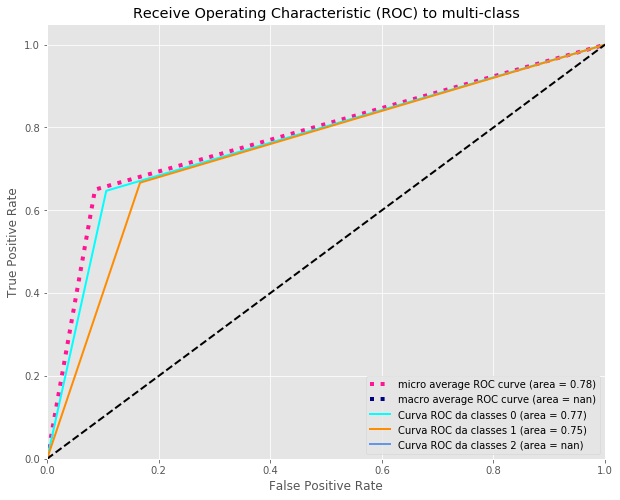



/n


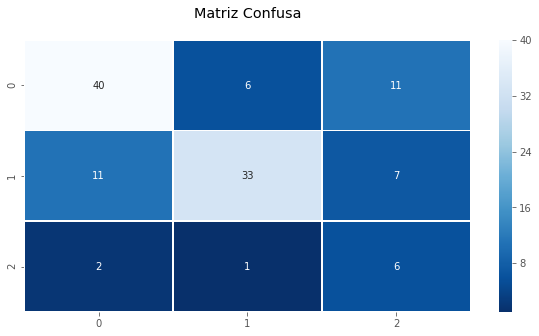

Accuracy = TP+TN/TP+FP+FN+TN
Valor: 0.6752136752136753
Precision = TP/TP+FP

Recall = TP/TP+FN

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

              precision    recall  f1-score   support

    NEGATIVO       0.75      0.70      0.73        57
    POSITIVO       0.82      0.65      0.73        51
      NEUTRO       0.25      0.67      0.36         9

    accuracy                           0.68       117
   macro avg       0.61      0.67      0.61       117
weighted avg       0.75      0.68      0.70       117



In [0]:
plot_learning_curve(clf, 'titulo', tfidf_train, y_train, ylim=(0.0,1.1), cv=5, n_jobs=1 )

# Fit dos dados de treinamento, para ensinamento da maquina
%time clf.fit(tfidf_train, y_train)
    
#Chamando classe predict para averiguação dos dados de teste
pred = clf.predict(tfidf_test)

    
# Gráfico para exibição das classes em predição    
sns.distplot(y_train, color='red')
sns.distplot(pred)
plt.title('Distribuição da classificação entre as classes')
plt.xlabel('Classes')
plt.ylabel('Quantidade')
plt.show()    

print("/n")
roc_auc(y_test, pred, n_classes=3)
print("/n")
confusion_report(ytest=y_test, predicao=pred)

### MLP - Multi Layer Perceptron

In [0]:
from sklearn.neural_network import MLPClassifier

In [0]:
clf = MLPClassifier(activation='relu',solver='adam', batch_size='auto', beta_1=0.9,
                    beta_2=0.999, early_stopping=True,epsilon=1e-08, alpha=1e-12,
                    hidden_layer_sizes=(350,),learning_rate='constant', learning_rate_init=0.01,
                    max_iter=200,momentum=0.9, n_iter_no_change=10,
                    nesterovs_momentum=True,power_t=0.5, random_state=1, shuffle=True, tol=0.001,
                    validation_fraction=0.1, verbose=True, warm_start=False)




Iteration 1, loss = 1.09956894
Validation score: 0.583333
Iteration 2, loss = 0.81669065
Validation score: 0.541667
Iteration 3, loss = 0.64823507
Validation score: 0.500000
Iteration 4, loss = 0.52116521
Validation score: 0.541667
Iteration 5, loss = 0.41881297
Validation score: 0.500000
Iteration 6, loss = 0.33534742
Validation score: 0.500000
Iteration 7, loss = 0.27250824
Validation score: 0.541667
Iteration 8, loss = 0.22459160
Validation score: 0.541667
Iteration 9, loss = 0.18563785
Validation score: 0.541667
Iteration 10, loss = 0.15894362
Validation score: 0.541667
Iteration 11, loss = 0.13995744
Validation score: 0.541667
Iteration 12, loss = 0.12452710
Validation score: 0.541667
Validation score did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
CPU times: user 167 ms, sys: 107 ms, total: 275 ms
Wall time: 286 ms


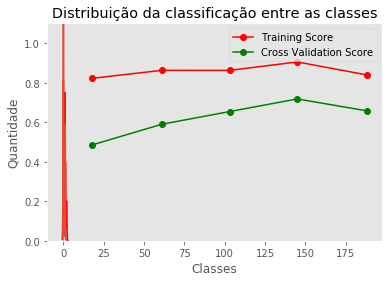

/n


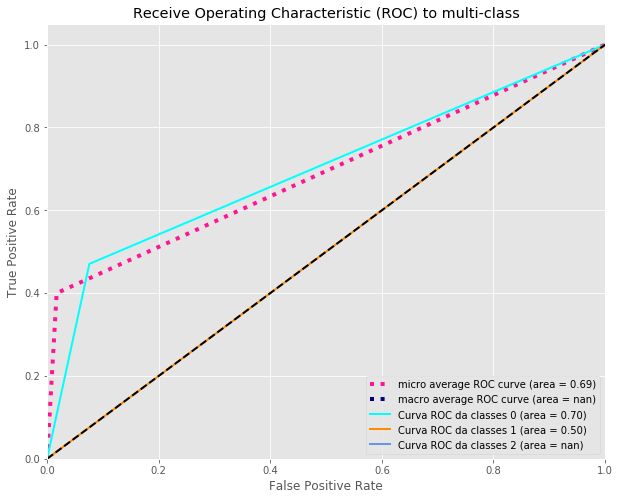



/n


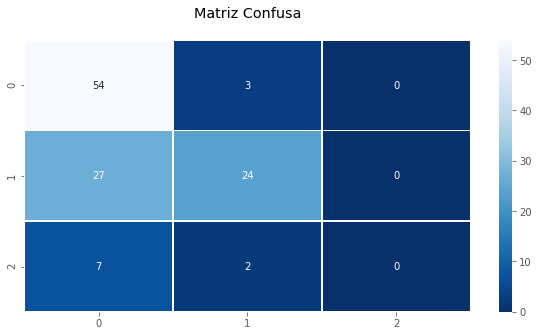

Accuracy = TP+TN/TP+FP+FN+TN
Valor: 0.6666666666666666
Precision = TP/TP+FP

Recall = TP/TP+FN

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

              precision    recall  f1-score   support

    NEGATIVO       0.61      0.95      0.74        57
    POSITIVO       0.83      0.47      0.60        51
      NEUTRO       0.00      0.00      0.00         9

    accuracy                           0.67       117
   macro avg       0.48      0.47      0.45       117
weighted avg       0.66      0.67      0.62       117



In [0]:
plot_learning_curve(clf, 'evaluation', tfidf_train, y_train, ylim=(0.0,1.1), cv=5, n_jobs=-1 )

# Fit dos dados de treinamento, para ensinamento da maquina
%time clf.fit(tfidf_train, y_train)
    
#Chamando classe predict para averiguação dos dados de teste
pred = clf.predict(tfidf_test)
    
# Gráfico para exibição das classes em predição    
sns.distplot(y_train, color='red')
sns.distplot(pred)
plt.title('Distribuição da classificação entre as classes')
plt.xlabel('Classes')
plt.ylabel('Quantidade')
plt.show()    
print("/n")
roc_auc(y_test, pred, n_classes=3)
print("/n")
confusion_report(ytest=y_test, predicao=pred)